# House Price Prediction (Adv. Regression)
## 1. Import all Dependencies

In [1]:
import os
import optuna # This import should now work after restarting the kernel
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
import tensorflow_decision_forests as tfdf
import tensorflow_probability as tfp

from scipy import stats
from catboost import CatBoostRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

# Create directories to save models
os.makedirs('saved_models', exist_ok=True)
os.makedirs('submissions', exist_ok=True)

2025-09-17 12:10:07.922961: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758111008.153596      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758111008.216965      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## 2. Load Dataset and Preprossing

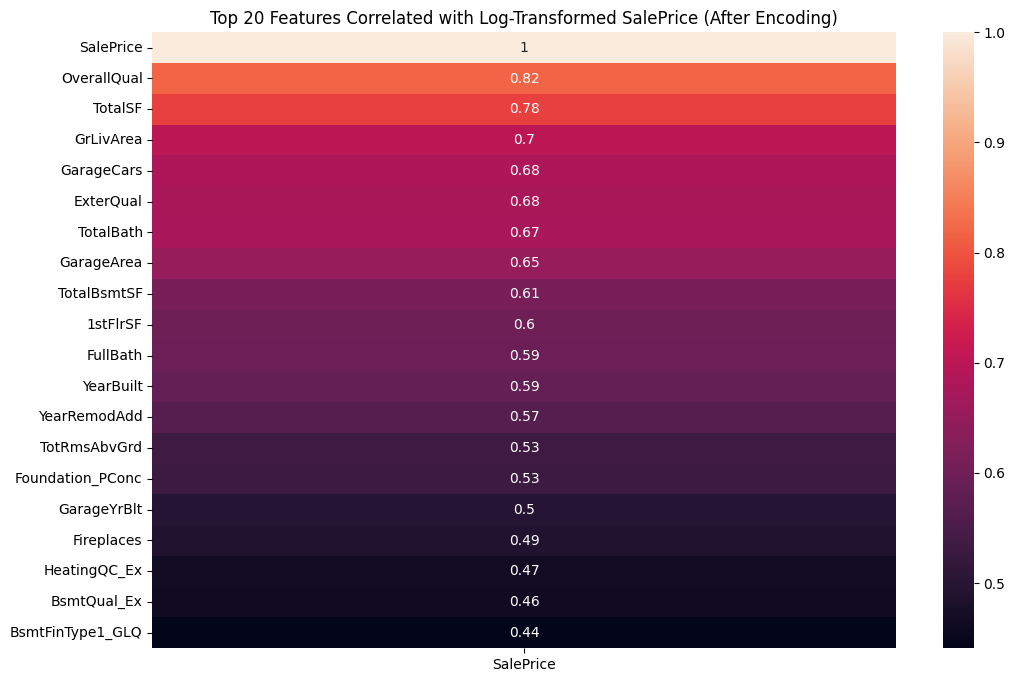

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


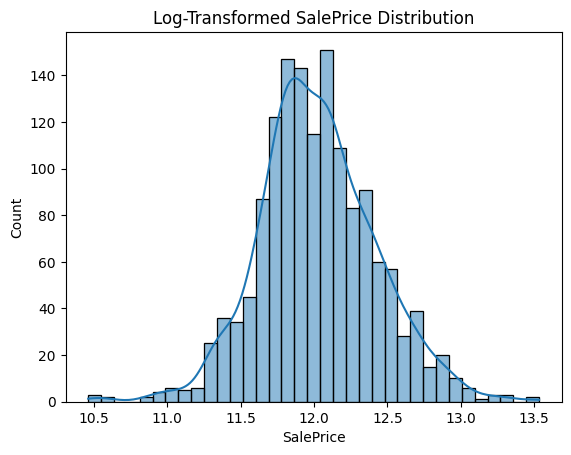

Shape of X_train: (1460, 303)
Shape of y_train: (1460,)
Shape of X_test: (1459, 303)
Shape of test_ids: (1459,)


In [2]:
# 1. Data Preparation
def load_and_preprocess():
    train = pd.read_csv(r"/kaggle/input/house-pricing-competition-dataset/train.csv")
    test = pd.read_csv(r"/kaggle/input/house-pricing-competition-dataset/test.csv")

    # Store the original 'Id' column for the test set before any modifications
    test_ids = test['Id']

    # Log-transform target
    train['SalePrice'] = np.log1p(train['SalePrice'])
    y_train = train['SalePrice']

    # Feature engineering
    def engineer_features(df):
        num_cols = df.select_dtypes(include=['int64', 'float64']).columns
        cat_cols = df.select_dtypes(include=['object']).columns

        # Fill missing numeric values with median
        for col in num_cols:
            # Check if the column exists in the DataFrame before filling
            if col in df.columns:
                 df[col] = df[col].fillna(df[col].median())

        # Fill missing categorical values with 'None'
        for col in cat_cols:
             # Check if the column exists in the DataFrame before filling
            if col in df.columns:
                 df[col] = df[col].fillna('None')


        # Engineered features
        df['TotalSF'] = df['1stFlrSF'] + df['2ndFlrSF'] + df['TotalBsmtSF']
        df['HouseAge'] = df['YrSold'] - df['YearBuilt']
        df['TotalBath'] = (df['FullBath'] + 0.5*df['HalfBath'] +
                          df['BsmtFullBath'] + 0.5*df['BsmtHalfBath'])

        # Mapping for ordinal categorical feature
        qual_map = {'None':0, 'Po':1, 'Fa':2, 'TA':3, 'Gd':4, 'Ex':5}
        # Check if 'ExterQual' exists before mapping
        if 'ExterQual' in df.columns:
            df['ExterQual'] = df['ExterQual'].map(qual_map)

        return df

    train = engineer_features(train)
    test = engineer_features(test)

    # Drop the original 'Id' and 'SalePrice' columns from the training set
    X_train = train.drop(['Id', 'SalePrice'], axis=1)
    # Drop the original 'Id' column from the test set
    X_test = test.drop('Id', axis=1)

    # One-hot encode CATEGORICAL columns BEFORE calculating correlation or proceeding
    # Identify categorical columns remaining after initial feature engineering
    # Need to re-identify object columns after engineer_features as some might be numeric now
    X_train_cat_cols = X_train.select_dtypes(include=['object']).columns
    X_test_cat_cols = X_test.select_dtypes(include=['object']).columns

    # Apply one-hot encoding
    X_train = pd.get_dummies(X_train, columns=X_train_cat_cols, dummy_na=False) # dummy_na=False is default, but good to be explicit
    X_test = pd.get_dummies(X_test, columns=X_test_cat_cols, dummy_na=False)

    # Align columns - very important after one-hot encoding
    X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

    # Now calculate and plot correlations AFTER one-hot encoding
    # Recombine X_train with y_train temporarily to calculate overall correlations
    train_encoded = pd.concat([X_train, y_train], axis=1)

    # Now it should be safe to calculate correlation as all features are numeric
    corr = train_encoded.corr()

    plt.figure(figsize=(12, 8))
    sns.heatmap(corr[['SalePrice']].sort_values('SalePrice', ascending=False).head(20), annot=True)
    plt.title('Top 20 Features Correlated with Log-Transformed SalePrice (After Encoding)')
    plt.show()

    # Plot the distribution AFTER log transformation
    sns.histplot(train['SalePrice'], kde=True)
    plt.title('Log-Transformed SalePrice Distribution')
    plt.show()


    return X_train, y_train, X_test, test_ids

# Call the function to load and preprocess the data
X_train, y_train, X_test, test_ids = load_and_preprocess()

# Print shapes to verify
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of test_ids:", test_ids.shape)

## 3. Dataset information

In [3]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Columns: 303 entries, MSSubClass to SaleCondition_Partial
dtypes: bool(263), float64(4), int64(36)
memory usage: 831.4 KB


## 4. Pseudolabeling

In [4]:
def pseudolabel(X_train, y_train, X_test, model, n_iter=2):
    for _ in range(n_iter):
        if isinstance(model, tf.keras.Model):
            # Neural network pseudolabeling
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            model.fit(X_train_scaled, y_train, epochs=50, verbose=0)
            test_preds = model.predict(scaler.transform(X_test)).flatten()
        else:
            # Tree-based model pseudolabeling
            model.fit(X_train, y_train)
            test_preds = model.predict(X_test)

        # Select predictions within 1 std of mean
        mask = np.abs(test_preds - test_preds.mean()) < test_preds.std()
        pseudo_features = X_test[mask].copy()

        # Create the pseudolabeled targets from test_preds based on the mask
        pseudo_targets = pd.Series(test_preds[mask], index=pseudo_features.index)

        # Concatenate the original X_train with the pseudolabeled features
        X_train = pd.concat([X_train, pseudo_features], ignore_index=True)

        # Concatenate the original y_train with the pseudolabeled targets
        y_train = pd.concat([y_train, pseudo_targets], ignore_index=True)

    return X_train, y_train

### 4.1 Bese model for pseudolabeling

In [5]:
# Initialize base model for pseudolabeling (using XGBoost as starter)
base_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
X_aug, y_aug = pseudolabel(X_train, y_train, X_test, base_model, n_iter=3)

# Prepare features
X = pd.get_dummies(X_aug)
y = y_aug


## 5. Check NULL values

In [6]:
X.isnull().sum()

MSSubClass               0
LotFrontage              0
LotArea                  0
OverallQual              0
OverallCond              0
                        ..
SaleCondition_AdjLand    0
SaleCondition_Alloca     0
SaleCondition_Family     0
SaleCondition_Normal     0
SaleCondition_Partial    0
Length: 303, dtype: int64



## 6. Model Training with Optuna Tuning


### 6.1 TF-DF + XGBoost + FNN Triple Ensemble

In [7]:
from sklearn.model_selection import cross_val_score, KFold
# 2.1 TF-DF + XGBoost + FNN Triple Ensemble
def train_tfdf(X, y):
    #Train a TensorFlow Decision Forest model with automatic feature name sanitization

    # Create temporary dataframe copy
    temp_df = X.copy()
    # convert boolean columns to int8
    for col in temp_df.columns:
        if temp_df[col].dtype == bool:
            temp_df[col] = temp_df[col].astype(np.int8)

    temp_df['SalePrice'] = y # Add target column

    # Convert to TF Dataset
    train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(
        temp_df,
        label='SalePrice',
        task=tfdf.keras.Task.REGRESSION
    )

    # Initialize model with name sanitization
    model = tfdf.keras.RandomForestModel(
        task=tfdf.keras.Task.REGRESSION)

    # Train model
    model.fit(train_ds)
    return model

# XGBoost
def train_xgb(X, y):
    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3, log=True),
            'subsample': trial.suggest_float('subsample', 0.6, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
            'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
            'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0)
        }
        model = xgb.XGBRegressor(**params, objective='reg:squarederror')
        return np.mean(cross_val_score(
            model, X, y,
            cv=KFold(n_splits=5, shuffle=True, random_state=42),
            scoring='neg_mean_squared_error',
            n_jobs=-1))

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=20, timeout=300)
    #study.optimize(objective, n_trials=100)
    #best_params = study.best_params
    best_model = xgb.XGBRegressor(**study.best_params, objective='reg:squarederror')
    best_model.fit(X, y, eval_set=[(X, y)], verbose=False)
    return best_model

In [8]:
def train_fnn(X, y):
    """Train Feedforward Neural Network with Optuna hyperparameter tuning"""
    # 1. Check for NaN values
    if y.isna().any():
        raise ValueError("Target variable y contains NaN values. Please clean your data first.")

    # 2. Scaling
    X_scaler = StandardScaler()
    y_scaler = StandardScaler()

    X_scaled = X_scaler.fit_transform(X)
    y_scaled = y_scaler.fit_transform(y.values.reshape(-1, 1)).flatten()

    # 3. Optuna optimization
    def objective(trial):
        # Model architecture
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(
                trial.suggest_int('units', 64, 512),
                activation=trial.suggest_categorical('activation', ['relu', 'elu', 'selu']),
                input_shape=(X_scaled.shape[1],), # Input_shape here
                kernel_initializer='he_normal'
            ),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(trial.suggest_float('dropout', 0.1, 0.4)),
            tf.keras.layers.Dense(1)
        ])

        # Optimizer selection
        optimizer_name = trial.suggest_categorical('optimizer', ['adam', 'nadam', 'sgd'])
        if optimizer_name == 'adam':
            lr = trial.suggest_float('adam_lr', 1e-5, 1e-2, log=True)
            optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
        elif optimizer_name == 'nadam':
            lr = trial.suggest_float('nadam_lr', 1e-5, 1e-2, log=True)
            optimizer = tf.keras.optimizers.Nadam(learning_rate=lr)
        else:  # sgd
            lr = trial.suggest_float('sgd_lr', 1e-5, 1e-2, log=True)
            momentum = trial.suggest_float('sgd_momentum', 0.8, 0.99)
            optimizer = tf.keras.optimizers.SGD(learning_rate=lr, momentum=momentum)

        model.compile(optimizer=optimizer, loss='mse')

        # Callbacks
        callbacks = [
            tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
            tf.keras.callbacks.TerminateOnNaN(),
            tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=5)
        ]

        # Training with validation split
        history = model.fit(
            X_scaled, y_scaled,
            epochs=100,
            batch_size=trial.suggest_categorical('batch_size', [32, 64, 128]),
            validation_split=0.2,
            verbose=0,
            callbacks=callbacks
        )

        # Return best validation loss
        return min(history.history['val_loss'])

    # 4. Run optimization
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=30, timeout=3600)

    # 5. Train final model with best params
    best_model = tf.keras.Sequential([
        tf.keras.layers.Dense(
            study.best_params['units'],
            activation=study.best_params['activation'],
            input_shape=(X_scaled.shape[1],), # Input_shape here
            kernel_initializer='he_normal'
        ),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(study.best_params['dropout']),
        tf.keras.layers.Dense(1)
    ])


    best_model.compile(
        optimizer=study.best_params['optimizer'],
        loss='mse',
        metrics = ['mae']
    )

    # Only use EarlyStopping callback (no ModelCheckpoint)
    callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True,
        verbose=1
    )]



    history = best_model.fit(
        X_scaled, y_scaled,
        epochs=200,
        batch_size=study.best_params['batch_size'],
        validation_split=0.2,
        verbose=1,
        callbacks= callbacks
    )

    return best_model, X_scaler, y_scaler

## 6.2 Training Models


In [9]:
tfdf_model = train_tfdf(X, y)

/tmp/ipykernel_13/2088461934.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  temp_df['SalePrice'] = y # Add target column
2025-09-17 12:10:36.014283: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Use /tmp/tmpw0iho77q as temporary training directory
Reading training dataset...
Training dataset read in 0:00:09.371954. Found 4715 examples.
Training model...


I0000 00:00:1758111045.747840      13 kernel.cc:782] Start Yggdrasil model training
I0000 00:00:1758111045.748856      13 kernel.cc:783] Collect training examples
I0000 00:00:1758111045.748884      13 kernel.cc:795] Dataspec guide:
column_guides {
  column_name_pattern: "^__LABEL$"
  type: NUMERICAL
}
default_column_guide {
  categorial {
    max_vocab_count: 2000
  }
  discretized_numerical {
    maximum_num_bins: 255
  }
}
ignore_columns_without_guides: false
detect_numerical_as_discretized_numerical: false

I0000 00:00:1758111045.750901      13 kernel.cc:401] Number of batches: 5
I0000 00:00:1758111045.750936      13 kernel.cc:402] Number of examples: 4715
I0000 00:00:1758111045.763123      13 kernel.cc:802] Training dataset:
Number of records: 4715
Number of columns: 304

Number of columns by type:
	NUMERICAL: 304 (100%)

Columns:

NUMERICAL: 304 (100%)
	0: "1stFlrSF" NUMERICAL mean:1130.87 min:334 max:5095 sd:349.469
	1: "2ndFlrSF" NUMERICAL mean:321.369 min:0 max:2065 sd:407.962


Model trained in 0:00:29.076380
Compiling model...


I0000 00:00:1758111074.652564      13 decision_forest.cc:761] Model loaded with 300 root(s), 390350 node(s), and 271 input feature(s).
I0000 00:00:1758111074.655900      13 abstract_model.cc:1404] Engine "RandomForestOptPred" built


Model compiled.


In [10]:
xgb_model = train_xgb(X, y)

[I 2025-09-17 12:11:19,593] A new study created in memory with name: no-name-6e5095bf-9a18-4471-a235-fe1095641a5d
[I 2025-09-17 12:11:44,987] Trial 0 finished with value: -0.004921156047078082 and parameters: {'n_estimators': 1088, 'max_depth': 7, 'learning_rate': 0.04596642586867274, 'subsample': 0.764898885363576, 'colsample_bytree': 0.8598429475944416, 'reg_alpha': 0.6384299608048345, 'reg_lambda': 0.67882103534975}. Best is trial 0 with value: -0.004921156047078082.
[I 2025-09-17 12:12:40,865] Trial 1 finished with value: -0.005589686832348574 and parameters: {'n_estimators': 1177, 'max_depth': 10, 'learning_rate': 0.006179442262282622, 'subsample': 0.6378724458566548, 'colsample_bytree': 0.948819556155093, 'reg_alpha': 0.7350898614368867, 'reg_lambda': 0.6518931534345973}. Best is trial 0 with value: -0.004921156047078082.
[I 2025-09-17 12:12:58,246] Trial 2 finished with value: -0.004714823410546505 and parameters: {'n_estimators': 1240, 'max_depth': 5, 'learning_rate': 0.0143768

In [11]:
fnn_model, fnn_scaler, y_fnn_scaler = train_fnn(X, y)

[I 2025-09-17 12:16:33,515] A new study created in memory with name: no-name-587b4322-f955-4815-8f4f-311b782f91d3
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
[I 2025-09-17 12:16:49,805] Trial 0 finished with value: 0.06265382468700409 and parameters: {'units': 248, 'activation': 'relu', 'dropout': 0.10324434362685045, 'optimizer': 'sgd', 'sgd_lr': 4.4256911409356654e-05, 'sgd_momentum': 0.9842387649250639, 'batch_size': 128}. Best is trial 0 with value: 0.06265382468700409.
[I 2025-09-17 12:17:37,097] Trial 1 finished with value: 0.047935549169778824 and parameters: {'units': 189, 'activation': 'selu', 'dropout': 0.35250843052702063, 'optimizer': 'nadam', 'nadam_lr': 2.9679241142121e-05, 'batch_size': 32

Epoch 1/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 1.4807 - mae: 0.8974 - val_loss: 0.2701 - val_mae: 0.3897
Epoch 2/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6623 - mae: 0.5991 - val_loss: 0.1539 - val_mae: 0.2856
Epoch 3/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5221 - mae: 0.5396 - val_loss: 0.1229 - val_mae: 0.2621
Epoch 4/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3871 - mae: 0.4752 - val_loss: 0.0986 - val_mae: 0.2340
Epoch 5/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2898 - mae: 0.4074 - val_loss: 0.0729 - val_mae: 0.2020
Epoch 6/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2508 - mae: 0.3796 - val_loss: 0.0494 - val_mae: 0.1730
Epoch 7/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2225 - mae: 0.3588 - val_loss: 0.0543 - val_mae: 0.1776
Epoch 8/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1720 - mae: 0.3201 - val_loss: 0.0434 - val_mae: 0.1568
Epoch 9/200
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.16

### 6.3 Save Models

In [12]:
# Save components
tfdf_model.save('saved_models/tfdf_model.keras')
joblib.dump(xgb_model, 'saved_models/xgb_model.pkl')
fnn_model.save('saved_models/fnn_model.keras')
joblib.dump(fnn_scaler, 'saved_models/fnn_scaler.pkl')

['saved_models/fnn_scaler.pkl']

## 7. Triple Ensemble
### 7.1 Pure Tree Ensemble (XGB + LGB + CatBoost)

In [13]:

# ### 2.2 Pure Tree Ensemble (XGB + LGB + CatBoost)
def train_tree_ensemble(X, y):
    # XGBoost (already trained)

    # LightGBM
    def tune_lgb(trial):
        params = {
            'num_leaves': trial.suggest_int('num_leaves', 20, 150),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2,log=True),
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
            'min_child_samples': trial.suggest_int('min_child_samples', 10, 100),
            'subsample': trial.suggest_float('subsample', 0.7, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 10.0, log=True),
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 10.0, log=True),
            'verbosity': -1,
            'random_state': 42
        }
        model = lgb.LGBMRegressor(**params)
        return np.mean(cross_val_score(
            model, X, y,
            cv=KFold(n_splits=5, shuffle=True, random_state=42),
            scoring='neg_mean_squared_error',
            n_jobs=-1
        ))

    study = optuna.create_study(direction='maximize')
    study.optimize(tune_lgb, n_trials=30, timeout=1800) # Reduced trials for efficiency

    # Train final LightGBM model with best parameters
    best_params = study.best_params.copy()
    best_params['verbosity'] = -1
    best_params['random_state'] = 42
    
    lgb_model = lgb.LGBMRegressor(**best_params)
    lgb_model.fit(X, y, eval_set=[(X, y)])

    # CatBoost
    cat_model = CatBoostRegressor(
        iterations=800,
        learning_rate=0.05,
        depth = 6,
        l2_leaf_reg = 3,
        random_seed = 42,
        verbose=0,
        early_stopping_rounds=50
    )
    cat_model.fit(X, y)


    # Create ensemble with dynamic weighting based on cross-validation performance
    # Get cross-validation scores to determine weights
    xgb_score = np.mean(cross_val_score(
        xgb_model, X, y, 
        cv=KFold(n_splits=3, shuffle=True, random_state=42),
        scoring='neg_mean_squared_error'
    ))
    
    lgb_score = np.mean(cross_val_score(
        lgb_model, X, y,
        cv=KFold(n_splits=3, shuffle=True, random_state=42),
        scoring='neg_mean_squared_error'
    ))
    
    cat_score = np.mean(cross_val_score(
        cat_model, X, y,
        cv=KFold(n_splits=3, shuffle=True, random_state=42),
        scoring='neg_mean_squared_error'
    ))
    
    # Calculate weights based on performance
    scores = np.array([xgb_score, lgb_score, cat_score])
    weights = np.exp(scores - np.max(scores))  # Softmax-like weighting
    weights = weights / weights.sum()
    
    print(f"Model weights - XGB: {weights[0]:.3f}, LGB: {weights[1]:.3f}, Cat: {weights[2]:.3f}")

    # Create ensemble
    ensemble = VotingRegressor(
        estimators=[('xgb', xgb_model), ('lgb', lgb_model), ('cat', cat_model)],
        weights=weights
    )
    ensemble.fit(X, y)

    return ensemble, lgb_model, cat_model

In [14]:
tree_ensemble, lgb_model, cat_model = train_tree_ensemble(X, y)

[I 2025-09-17 12:29:16,780] A new study created in memory with name: no-name-8fffad93-497f-423c-bc84-feab4b39ae20
[I 2025-09-17 12:29:47,851] Trial 0 finished with value: -0.005460132504120025 and parameters: {'num_leaves': 41, 'max_depth': 10, 'learning_rate': 0.021235502913590575, 'n_estimators': 662, 'min_child_samples': 57, 'subsample': 0.7244571260365199, 'colsample_bytree': 0.9632778502803585, 'reg_alpha': 2.2193156416215582e-06, 'reg_lambda': 3.5290313194126263e-07}. Best is trial 0 with value: -0.005460132504120025.
[I 2025-09-17 12:29:51,367] Trial 1 finished with value: -0.0056418221308945265 and parameters: {'num_leaves': 47, 'max_depth': 3, 'learning_rate': 0.12088845643542798, 'n_estimators': 659, 'min_child_samples': 86, 'subsample': 0.7737819403046089, 'colsample_bytree': 0.742179312976851, 'reg_alpha': 0.015557676423133642, 'reg_lambda': 7.229039455447222e-06}. Best is trial 0 with value: -0.005460132504120025.
[I 2025-09-17 12:30:03,097] Trial 2 finished with value: -0

Model weights - XGB: 0.333, LGB: 0.333, Cat: 0.333


### 7.2 Save Models (Ensemble Models)

In [15]:
# Save models
joblib.dump(tree_ensemble, 'saved_models/tree_ensemble.pkl')
joblib.dump(lgb_model, 'saved_models/lgb_model.pkl')
joblib.dump(cat_model, 'saved_models/cat_model.pkl')

['saved_models/cat_model.pkl']

## 8. Cross-Validation & A/B Testing

In [16]:
scaler = StandardScaler()
X_test_scaled = scaler.fit_transform(X)


def cross_val_ab_test(model_builders, model_names, X, y, n_splits=5):
    kf = KFold(n_splits=n_splits)
    results = {name: {'rmse': [], 'predictions': []} for name in model_names}

    for train_idx, val_idx in kf.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        # Train/test each model
        for name, model_builder in zip(model_names, model_builders):
            model = model_builder()
            preds = None

            try:
                if isinstance(model, VotingRegressor):
                    # Handle voting regressor case
                    ensemble_preds = []
                    for est_name, estimator in model.estimators:
                        if isinstance(estimator, tf.keras.Sequential):  # FNN case
                            scaler = StandardScaler()
                            X_train_scaled = scaler.fit_transform(X_train)
                            X_val_scaled = scaler.transform(X_val)
                            estimator.fit(X_train_scaled, y_train, epochs=50, verbose=0)
                            pred = estimator.predict(X_val_scaled).flatten()
                        elif isinstance(estimator, tfdf.keras.RandomForestModel):  # TFDF case
                            train_df = X_train.copy()
                            for col in train_df.columns:
                                if train_df[col].dtype == bool:
                                    train_df[col] = train_df[col].astype(np.int8)
                            train_df['target'] = y_train
                            train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(
                                train_df, label='target', task=tfdf.keras.Task.REGRESSION
                            )
                            estimator.fit(train_ds, verbose=0)
                            val_df = X_val.copy()
                            for col in val_df.columns:
                                if val_df[col].dtype == bool:
                                    val_df[col] = val_df[col].astype(np.int8)
                            val_ds = tfdf.keras.pd_dataframe_to_tf_dataset(val_df)
                            pred = estimator.predict(val_ds).flatten()
                        else:  # Regular sklearn models
                            estimator.fit(X_train, y_train)
                            pred = estimator.predict(X_val)
                        ensemble_preds.append(pred)
                    preds = np.average(ensemble_preds, axis=0, weights=model.weights)

                elif isinstance(model, tf.keras.Sequential):  # Single FNN
                    scaler = StandardScaler()
                    X_train_scaled = scaler.fit_transform(X_train)
                    X_val_scaled = scaler.transform(X_val)
                    model.fit(X_train_scaled, y_train, epochs=50, verbose=0)
                    preds = model.predict(X_val_scaled).flatten()

                elif isinstance(model, tfdf.keras.RandomForestModel):  # Single TFDF
                    train_df = X_train.copy()
                    for col in train_df.columns:
                        if train_df[col].dtype == bool:
                            train_df[col] = train_df[col].astype(np.int8)
                    train_df['target'] = y_train
                    train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(
                        train_df, label='target', task=tfdf.keras.Task.REGRESSION
                    )
                    model.fit(train_ds, verbose=0)
                    val_df = X_val.copy()
                    for col in val_df.columns:
                        if val_df[col].dtype == bool:
                            val_df[col] = val_df[col].astype(np.int8)
                    val_ds = tfdf.keras.pd_dataframe_to_tf_dataset(val_df)
                    preds = model.predict(val_ds).flatten()

                else:  # Regular sklearn models
                    model.fit(X_train, y_train)
                    preds = model.predict(X_val)

                if preds is None:
                    raise ValueError(f"Predictions not generated for model: {name}")

                rmse = np.sqrt(mean_squared_error(y_val, preds))
                results[name]['rmse'].append(rmse)
                results[name]['predictions'].append({
                    'fold': kf,
                    'y_true': y_val.values,
                    'y_pred': preds,
                    'indices': val_idx
                })

            except Exception as e:
                print(f"Error evaluating model {name}: {str(e)}")
                continue

    # Calculate statistics
    stats_df = pd.DataFrame()
    for name in model_names:
        if results[name]['rmse']:  # Only if we have results
            stats_df.loc[name, 'Mean RMSE'] = np.mean(results[name]['rmse'])
            stats_df.loc[name, 'Std RMSE'] = np.std(results[name]['rmse'])

    # Pairwise t-tests
    for i in range(len(model_names)):
        for j in range(i+1, len(model_names)):
            if results[model_names[i]]['rmse'] and results[model_names[j]]['rmse']:
                t_stat, p_value = stats.ttest_rel(results[model_names[i]]['rmse'], results[model_names[j]]['rmse'])
                stats_df.loc[model_names[i], f'p vs {model_names[j]}'] = p_value

    return stats_df

In [17]:
# Define models to compare
models_to_test = [
    lambda: (tfdf.keras.RandomForestModel(task=tfdf.keras.Task.REGRESSION), xgb.XGBRegressor(**xgb_model.get_params()), tf.keras.models.clone_model(fnn_model)),  # Triple Ensemble 1; # TFDF+XGB+FNN
    lambda: (xgb.XGBRegressor(**xgb_model.get_params()), lgb.LGBMRegressor(**lgb_model.get_params()), tf.keras.models.clone_model(fnn_model)),    # Triple Ensemble 2; # XGB+LGB+FNN
    lambda: VotingRegressor(estimators=[('xgb', xgb.XGBRegressor(**xgb_model.get_params())), ('lgb', lgb.LGBMRegressor(**lgb_model.get_params())), ('cat', CatBoostRegressor(iterations=1000, verbose=0))]) # Pure Tree Ensemble
]

model_names = [
    'TFDF+XGB+FNN',
    'XGB+LGB+FNN',
    'Tree Ensemble'
]


# Run A/B tests
ab_results = cross_val_ab_test(models_to_test, model_names, X, y)

# Create directory
os.makedirs('ab_test_results', exist_ok=True)
# Save results
ab_results.to_csv('ab_test_results/model_comparison.csv')
print(ab_results)

Use /tmp/tmpwfnhatbr as temporary training directory
Error evaluating model TFDF+XGB+FNN: 'tuple' object has no attribute 'fit'
Error evaluating model XGB+LGB+FNN: 'tuple' object has no attribute 'fit'
Use /tmp/tmp22yrmtc3 as temporary training directory
Error evaluating model TFDF+XGB+FNN: 'tuple' object has no attribute 'fit'
Error evaluating model XGB+LGB+FNN: 'tuple' object has no attribute 'fit'
Use /tmp/tmpzvlxyavu as temporary training directory
Error evaluating model TFDF+XGB+FNN: 'tuple' object has no attribute 'fit'
Error evaluating model XGB+LGB+FNN: 'tuple' object has no attribute 'fit'
Use /tmp/tmp668zc_sf as temporary training directory
Error evaluating model TFDF+XGB+FNN: 'tuple' object has no attribute 'fit'
Error evaluating model XGB+LGB+FNN: 'tuple' object has no attribute 'fit'
Use /tmp/tmpt5q4frbb as temporary training directory
Error evaluating model TFDF+XGB+FNN: 'tuple' object has no attribute 'fit'
Error evaluating model XGB+LGB+FNN: 'tuple' object has no attrib

## 9. Final Ensemble Predictions

In [18]:
# ## 4. Final Ensemble Predictions
def predict_ensemble(models, X, is_nn=False, scaler=None):
    if is_nn:
        X_scaled = scaler.transform(X)
        return models.predict(X_scaled).flatten()


    # Special handling for TFDF models
    if isinstance(models, tfdf.keras.RandomForestModel):
        # Convert DataFrame to TFDF-compatible format
        X_df = X.copy()
        for col in X_df.columns:
            if X_df[col].dtype == bool:
                X_df[col] = X_df[col].astype(np.int8)
            elif X_df[col].dtype == object:
                # Handle categorical columns if needed
                X_df[col] = X_df[col].astype(str)

        # Convert to TF Dataset
        test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(X_df)
        return models.predict(test_ds).flatten()

    # Regular sklearn models
    return models.predict(X)

# Triple Ensemble 1 (TFDF + XGB + FNN)
tfdf_preds = predict_ensemble(tfdf_model, X_test)
xgb_preds = predict_ensemble(xgb_model, X_test)
fnn_preds = predict_ensemble(fnn_model, X_test, is_nn=True, scaler=fnn_scaler)
triple1_preds = 0.4*tfdf_preds + 0.3*xgb_preds + 0.3*fnn_preds

# Triple Ensemble 2 (XGB + LGB + FNN)
lgb_preds = predict_ensemble(lgb_model, X_test)
triple2_preds = 0.4*xgb_preds + 0.3*lgb_preds + 0.3*fnn_preds


# Pure Tree Ensemble
tree_preds = predict_ensemble(tree_ensemble, X_test)

# Create submissions
submissions = {
    'triple1': np.expm1(triple1_preds),
    'triple2': np.expm1(triple2_preds),
    'tree': np.expm1(tree_preds),
    # 'bnn_fnn': np.expm1(bnn_fnn_preds)
}

for name, preds in submissions.items():
    pd.DataFrame({'Id': test_ids, 'SalePrice': preds}).to_csv(
        f'submissions/{name}_submission.csv', index=False
    )

2/2 [==============================] - 1s 82ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


## 10. Model Performance Summary

In [19]:
# ## 5. Model Performance Summary
performance_summary = pd.DataFrame({
    'Model': ab_results.index,  # Use index from ab_results instead of model_names
    'CV RMSE': ab_results['Mean RMSE'],
    'CV Std': ab_results['Std RMSE']
}).reset_index(drop=True)  # Reset index to avoid potential index mismatch

# Add statistical significance markers
for i in range(len(performance_summary)):
    for j in range(i+1, len(performance_summary)):
        model_i = performance_summary.loc[i, 'Model']
        model_j = performance_summary.loc[j, 'Model']

        # Check if the p-value column exists in ab_results
        p_val_col = f'p vs {model_j}'
        if p_val_col in ab_results.columns:
            p_val = ab_results.loc[model_i, p_val_col]
            if p_val < 0.05:
                performance_summary.loc[i, f'Better than {model_j}'] = 'Yes'
            else:
                performance_summary.loc[i, f'Better than {model_j}'] = 'No'

# Ensure directory exists
os.makedirs('ab_test_results', exist_ok=True)

# Save and display
performance_summary.to_csv('ab_test_results/performance_summary.csv', index=False)
print(performance_summary)

           Model   CV RMSE    CV Std
0  Tree Ensemble  0.051493  0.045144
